In [8]:
import pandas as pd
import numpy as np

import seaborn as sns

from sklearn import metrics

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedKFold, KFold, train_test_split, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB

from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import IsolationForest

from category_encoders import MEstimateEncoder

import lightgbm

import catboost

import xgboost

import matplotlib.pyplot as plt

from datetime import date
import math

from optuna import trial
import optuna

In [88]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [89]:
train['last_lead'] = (pd.to_datetime('2022-01-01') - pd.to_datetime(train['created_at'])).dt.days
test['last_lead'] = (pd.to_datetime('2022-01-01') - pd.to_datetime(test['created_at'])).dt.days

In [90]:
train['month'] = train['created_at'].apply(lambda x: pd.to_datetime(x).month)
test['month'] =test['created_at'].apply(lambda x: pd.to_datetime(x).month)

d:\python3.9\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='buy', ylabel='count'>

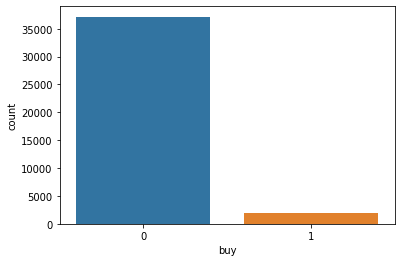

In [411]:
sns.countplot(train['buy'])

<AxesSubplot:xlabel='campaign_var_2', ylabel='count'>

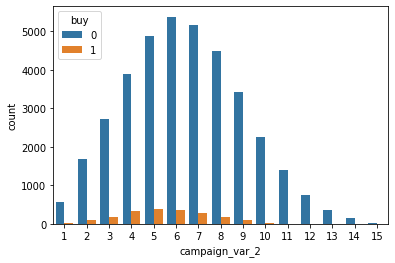

In [431]:
sns.countplot(x=train['campaign_var_2'], hue=train['buy'])

d:\python3.9\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='products_purchased', ylabel='count'>

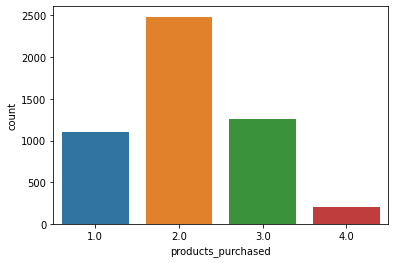

In [413]:
sns.countplot(test['products_purchased'])

In [414]:
import scipy.stats as ss

In [415]:
def cramers_v(x, y):
    
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [91]:
train['last_lead'] = train['last_lead'].astype('int')
test['last_lead'] = test['last_lead'].astype('int')

In [92]:
train.loc[train['signup_date'].isnull() , 'products_purchased'] = 0
test.loc[test['signup_date'].isnull() , 'products_purchased'] = 0

In [69]:
train.loc[train['products_purchased'].isnull() , 'products_purchased'] = 1
test.loc[test['products_purchased'].isnull() , 'products_purchased'] = 1

In [71]:
train.isnull().sum()

id                          0
created_at                  0
campaign_var_1              0
campaign_var_2              0
products_purchased          0
signup_date             15113
user_activity_var_1         0
user_activity_var_2         0
user_activity_var_3         0
user_activity_var_4         0
user_activity_var_5         0
user_activity_var_6         0
user_activity_var_7         0
user_activity_var_8         0
user_activity_var_9         0
user_activity_var_10        0
user_activity_var_11        0
user_activity_var_12        0
buy                         0
last_lead                   0
dtype: int64

In [419]:
for var in train.drop(['id', 'created_at','signup_date','buy'], axis = 1).columns:
    a = cramers_v(train[var],train['buy'])
    print('{0} : {1}'.format(var,a))

campaign_var_1 : 0.08889827938655041
campaign_var_2 : 0.09555762684336691
products_purchased : 0.19010331053454008
user_activity_var_1 : 0.05354753689482219
user_activity_var_2 : 0.3538850631715588
user_activity_var_3 : 0.0
user_activity_var_4 : 0.3941334384683621
user_activity_var_5 : 0.17923762971857568
user_activity_var_6 : 0.008409502141363205
user_activity_var_7 : 0.027987568006274905
user_activity_var_8 : 0.09711593514105682
user_activity_var_9 : 0.46337958015948244
user_activity_var_10 : 0.08130151963781729
user_activity_var_11 : 0.37505167815364615
user_activity_var_12 : 0.06532375683956304
last_lead : 0.019178438296359977
month : 0.01877726831882949


In [9]:
skf = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)

In [40]:
est = catboost.CatBoostClassifier(random_state=42)

In [41]:
distributions = {
                    'learning_rate': [0.1,0.2,0.3, 0.01,0.02,0.03,0.5,0.04], 
                    'max_depth': [1,2,3,4,5,6,7,8,9,10,11], 
                    'loss_function': ['Logloss'],
                    'custom_metric':['F1'],
                    'scale_pos_weight': [2,2.5,3,3.5,4],
                    'min_data_in_leaf': [30,40,50,60,70,80,90],
                    'l2_leaf_reg': [1,4,9],
                    'subsample': [0.5,0.6,0.7,0.8],
                    'colsample_bylevel': [0.5,0.6,0.7,0.8]
                    
}

In [42]:
clf = RandomizedSearchCV(est, distributions, n_iter=10, cv= skf, scoring='f1', random_state=42)

In [43]:
clf.fit(train.drop(['id','created_at','signup_date','buy','user_activity_var_10', 'user_activity_var_12'],axis=1), train['buy'], verbose=500, early_stopping_rounds=100)

0:	learn: 0.6535324	total: 10.5ms	remaining: 10.5s
500:	learn: 0.1778626	total: 7.03s	remaining: 7s
999:	learn: 0.1669772	total: 14.8s	remaining: 0us
0:	learn: 0.6540282	total: 18.9ms	remaining: 18.9s
500:	learn: 0.1785026	total: 7.37s	remaining: 7.34s
999:	learn: 0.1675430	total: 14.3s	remaining: 0us
0:	learn: 0.6537909	total: 17.1ms	remaining: 17s
500:	learn: 0.1761228	total: 7.24s	remaining: 7.21s
999:	learn: 0.1653743	total: 15.1s	remaining: 0us
0:	learn: 0.6535051	total: 18.1ms	remaining: 18.1s
500:	learn: 0.1784366	total: 8.26s	remaining: 8.23s
999:	learn: 0.1680791	total: 15.3s	remaining: 0us
0:	learn: 0.6540160	total: 18.5ms	remaining: 18.5s
500:	learn: 0.1808037	total: 7.19s	remaining: 7.16s
999:	learn: 0.1694687	total: 14.5s	remaining: 0us
0:	learn: 0.6438624	total: 21ms	remaining: 21s
500:	learn: 0.1292991	total: 9.79s	remaining: 9.75s
999:	learn: 0.1164493	total: 19.6s	remaining: 0us
0:	learn: 0.6414092	total: 21.5ms	remaining: 21.4s
500:	learn: 0.1289154	total: 10s	remaini

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x00000258D61194C0>,
                   param_distributions={'colsample_bylevel': [0.5, 0.6, 0.7,
                                                              0.8],
                                        'custom_metric': ['F1'],
                                        'l2_leaf_reg': [1, 4, 9],
                                        'learning_rate': [0.1, 0.2, 0.3, 0.01,
                                                          0.02, 0.03, 0.5,
                                                          0.04],
                                        'loss_function': ['Logloss'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11],
                                        'min_data_in_leaf': [30, 40, 50, 60, 70,
                                  

In [45]:
clf.best_params_, clf.best_score_

({'subsample': 0.7,
  'scale_pos_weight': 2.5,
  'min_data_in_leaf': 30,
  'max_depth': 8,
  'loss_function': 'Logloss',
  'learning_rate': 0.01,
  'l2_leaf_reg': 4,
  'custom_metric': 'F1',
  'colsample_bylevel': 0.6},
 0.7017028519206174)

In [16]:
metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [72]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [97]:
def train_and_evaluate(train, test, params):
    
    
    
    
    # Split features and target
    #x = train[['user_activity_var_2','user_activity_var_4','user_activity_var_5','user_activity_var_9','user_activity_var_11','products_purchased']]
    x = train.drop(['id','created_at','signup_date','buy','user_activity_var_10', 'user_activity_var_12'],axis=1)
    y = train['buy']
    #x_test = test[['user_activity_var_2','user_activity_var_4','user_activity_var_5','user_activity_var_9','user_activity_var_11','products_purchased']]
    x_test = test.drop(['id','created_at','signup_date','user_activity_var_10', 'user_activity_var_12'],axis=1)
    #print(x.shape[0])
    # Create out of folds array
    oof_predictions = np.zeros(x.shape[0])
    # Create test array to store predictions
    test_predictions = np.zeros(x_test.shape[0])
    
    oof_predictions1 = np.zeros(x.shape[0])
    # Create test array to store predictions
    test_predictions1 = np.zeros(x_test.shape[0])
    
    oof_predictions2 = np.zeros(x.shape[0])
    # Create test array to store predictions
    test_predictions2 = np.zeros(x_test.shape[0])
    
    # Create a KFold object
    kfold = StratifiedKFold(n_splits = 5, random_state = 66, shuffle = True)
    # Iterate through each fold
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(x, y=y.values)):
        print(f'Training fold {fold + 1}')
        x_train, x_val = x.iloc[trn_ind], x.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        
        
        #model = LogisticRegression(random_state=42, max_iter=1000, class_weight={0:.2, 1:.8})
        
        #model1 = lightgbm.LGBMClassifier(objective='binary', random_state=42, min_gain_to_split=3,num_leaves=100,scale_pos_weight=3,
        #                                 metric='binary_logloss',
        #                                 learning_rate=0.1, n_estimators=1000, max_depth=5, subsample=0.8 )
        
        #model = GaussianNB()
        #model = catboost.CatBoostClassifier(random_seed=42, eval_metric='F1',  loss_function='Logloss',
        #                                    custom_metric=['F1'], bagging_temperature=0.5, l2_leaf_reg=0.5,
        #                                    verbose=500,learning_rate=0.1, max_depth=5,scale_pos_weight=3)
        model = catboost.CatBoostClassifier(**params)
        #model2 = xgboost.XGBClassifier(objective='binary:logistic', learning_rate=0.1, random_state=42,max_depth=5,
        #                               n_estimators=1000, use_label_encoder=False, scale_pos_weight=3)
        
        #model2 = DecisionTreeClassifier(random_state=42, max_depth=7)
        
        '''
        for col in x.columns:
            encoder = MEstimateEncoder(m=3.5)
            encoder.fit(x_train[col], y_train)
            x_train[col] = encoder.transform(x_train[col])
            x_val[col] = encoder.transform(x_val[col])
            x_test[col] = encoder.transform(x_test[col])
            
        '''
        
        model.fit(x_train, y_train, early_stopping_rounds=50, eval_set=(x_val, y_val), use_best_model=True)
        #model.fit(x_train, y_train)
        
        #model1.fit(x_train, y_train, early_stopping_rounds=50, eval_set=(x_val, y_val), verbose=500)
        
        #model2.fit(x_train, y_train, early_stopping_rounds=50, eval_set=[(x_train, y_train), (x_val, y_val)], verbose=500)
        
        #model.fit(x_train, y_train)
        
        #val_pred = model.predict_proba(x_val)
        
        val_pred = model.predict(x_val)
        
        #val_pred1 = model1.predict(x_val)
        
        #val_pred2 = model2.predict(x_val)
        print(val_pred)
        
        #val = np.argmax(val_pred, axis=1)
        
        # Add predictions to the out of folds array
        
        oof_predictions[val_ind] =  val_pred
        
        #oof_predictions1[val_ind] =  val_pred1
        
        #oof_predictions2[val_ind] =  val_pred2
        
        
        # Predict the test set
        
        #xgb_pred = np.argmax(model.predict_proba(x_test), axis=1)
        pred = model.predict(x_test)
        
        #pred1 = model1.predict(x_test)
        
        #pred2 = model2.predict(x_test)
        
        #plot_feature_importance(model1.feature_importances_, x.columns,'CAT BOOST')
        
        
        test_predictions += pred
        
        #test_predictions1 += pred1
        
        #test_predictions2 += pred2
        
        
        
        
        
    score = metrics.f1_score(y, oof_predictions)
    #score1 = metrics.f1_score(y, oof_predictions1)
    #score2 = metrics.f1_score(y, oof_predictions2)
    
    
    
    precision = metrics.precision_score(y, oof_predictions)
    
    recall = metrics.recall_score(y, oof_predictions)
    print(f'Our out of folds f1 score is {score}')
    #print(f'Our out of folds f1 score is {score1}')
    #print(f'Our out of folds f1 score is {score2}')
    #print(f'Our out of folds precision score is {precision}')
    #print(f'Our out of folds recall score is {recall}')
    
    #print(metrics.confusion_matrix(train['buy'], oof_predictions))
    return score
    # Return test predictions
    #return [round(x/5) for x in test_predictions]
    #return [round(x/5) for x in test_predictions],oof_predictions,[round(x/5) for x in test_predictions1],oof_predictions1,[round(x/5) for x in test_predictions2],oof_predictions2

Training fold 1
0:	learn: 0.6884980	test: 0.6829268	best: 0.6829268 (0)	total: 18.3ms	remaining: 18.3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.745490982
bestIteration = 114

Shrink model to first 115 iterations.
[LightGBM] [Warning] min_gain_to_split is set=3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.0992058
[12:41:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.61417	validation_1-logloss:0.61422
[299]	validation_0-logloss:0.07722	validation_1-logloss:0.09774
[0 0 0 ... 0 0 0]
Training fold 2
0:	learn: 0.6842034	test: 0.70000

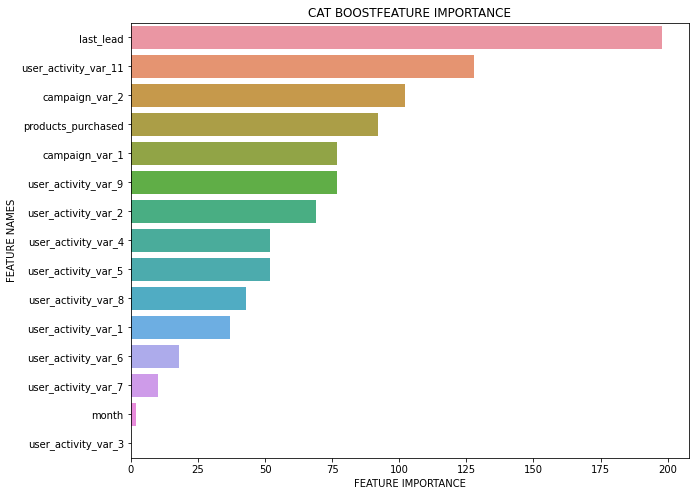

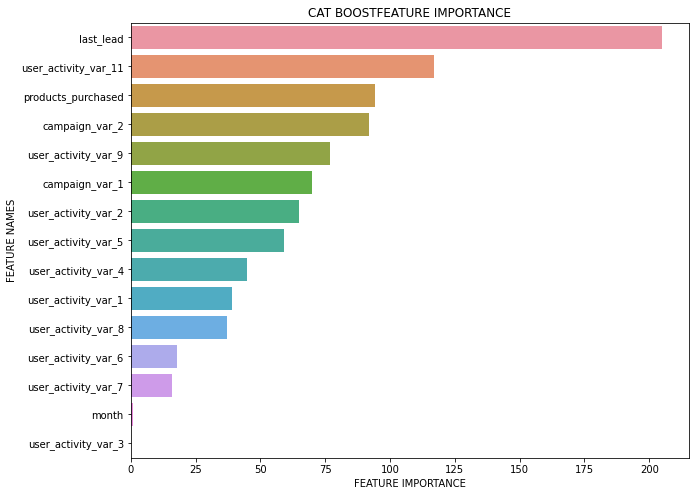

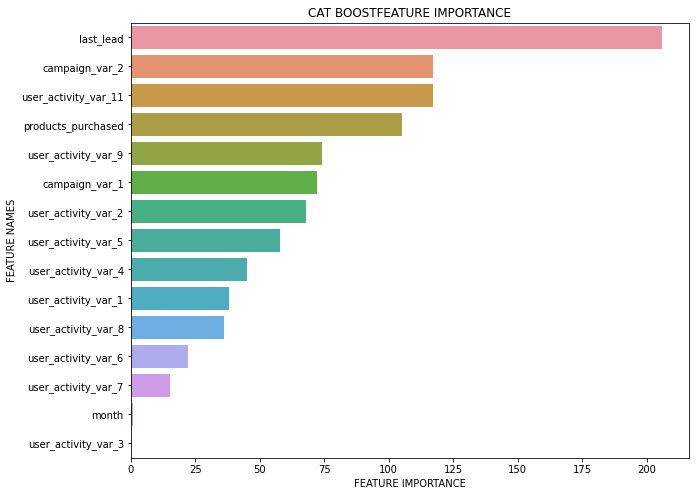

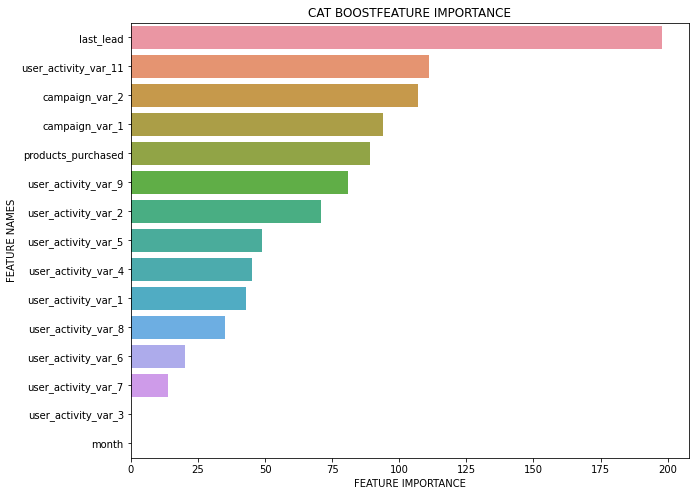

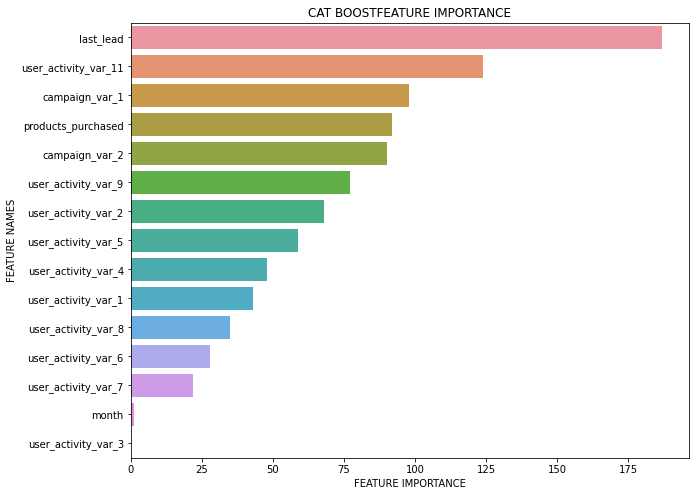

In [96]:
%%time
#test_predictions,oof = train_and_evaluate(train, test)
test_predictions,oof,test_predictions1,oof1,test_predictions2,oof2 = train_and_evaluate(train, test)

#test_predictions = train_and_evaluate(train, test)

In [107]:
def objective(trial):
    params_hist = {
        
        #'loss':trial.suggest_categorical("loss",["poisson","squared_error"]),
        "learning_rate": trial.suggest_float("learning_rate", 0.05,0.2),
        "max_depth":trial.suggest_int("max_depth",3,10),
        #"iterations":trial.suggest_int("iterations",100,1000),
        'eval_metric':'F1',  
        'loss_function':'Logloss',
        'custom_metric':['F1'],
        #'subsample': trial.suggest_float("subsample",0.5,1),
        "l2_leaf_reg":trial.suggest_int("l2_leaf_reg",1,4),
        #'scoring':"neg_root_mean_squared_error",
        #"early_stopping":50,
        'random_state':42,
        'verbose':500,
    }
    
    score = train_and_evaluate(train,test, params_hist)
    
    return score
    

In [108]:
study = optuna.create_study()
study.optimize(objective, n_jobs=4, n_trials=10)
print("Best hyperparameters: {}".format(study.best_trial.params))

[I 2022-06-05 13:12:59,480] A new study created in memory with name: no-name-2ec87ca5-aacb-43d8-954f-83a5c1ebf20f
d:\python3.9\lib\site-packages\optuna\study\study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Training fold 1
Training fold 1
Training fold 1
Training fold 1
0:	learn: 0.4803037	test: 0.4962406	best: 0.4962406 (0)	total: 22ms	remaining: 22s
0:	learn: 0.4803037	test: 0.4962406	best: 0.4962406 (0)	total: 17.9ms	remaining: 17.9s
0:	learn: 0.4803037	test: 0.4962406	best: 0.4962406 (0)	total: 19.5ms	remaining: 19.5s
0:	learn: 0.4803037	test: 0.4962406	best: 0.4962406 (0)	total: 26.2ms	remaining: 26.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6848874598
bestIteration = 72

Shrink model to first 73 iterations.
[0 0 0 ... 0 0 0]
Training fold 2
0:	learn: 0.4769158	test: 0.5092937	best: 0.5092937 (0)	total: 16.5ms	remaining: 16.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6910828025
bestIteration = 4

Shrink model to first 5 iterations.
[0 0 0 ... 0 0 0]
Training fold 3
0:	learn: 0.4860520	test: 0.4732824	best: 0.4732824 (0)	total: 22.2ms	remaining: 22.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6912
bestIte

[I 2022-06-05 13:13:15,350] Trial 3 finished with value: 0.6864324846922335 and parameters: {'learning_rate': 0.06345746612290692, 'max_depth': 4, 'l2_leaf_reg': 3}. Best is trial 3 with value: 0.6864324846922335.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6688417618
bestIteration = 85

Shrink model to first 86 iterations.
[0 0 0 ... 0 0 0]
Our out of folds f1 score is 0.6864324846922335
Training fold 1
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.701754386
bestIteration = 22

Shrink model to first 23 iterations.
0:	learn: 0.4803037	test: 0.4962406	best: 0.4962406 (0)	total: 12.3ms	remaining: 12.3s
[0 0 0 ... 1 0 0]
Training fold 4
0:	learn: 0.4831833	test: 0.4848485	best: 0.4848485 (0)	total: 25.3ms	remaining: 25.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.701754386
bestIteration = 108

Shrink model to first 109 iterations.
[0 0 0 ... 0 0 0]
Training fold 5
0:	learn: 0.4910462	test: 0.4526112	best: 0.4526112 (0)	total: 26ms	remaining: 26s


[I 2022-06-05 13:13:18,265] Trial 1 finished with value: 0.6891025641025641 and parameters: {'learning_rate': 0.08332768871204538, 'max_depth': 3, 'l2_leaf_reg': 4}. Best is trial 3 with value: 0.6864324846922335.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.667752443
bestIteration = 99

Shrink model to first 100 iterations.
[0 0 0 ... 0 0 0]
Our out of folds f1 score is 0.6891025641025641
Training fold 1
0:	learn: 0.6789432	test: 0.6720000	best: 0.6720000 (0)	total: 32.3ms	remaining: 32.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6666666667
bestIteration = 22

Shrink model to first 23 iterations.
[0 0 0 ... 0 0 0]
Our out of folds f1 score is 0.6957908163265306

[I 2022-06-05 13:13:19,454] Trial 0 finished with value: 0.6957908163265306 and parameters: {'learning_rate': 0.11664814895460579, 'max_depth': 5, 'l2_leaf_reg': 1}. Best is trial 3 with value: 0.6864324846922335.



Training fold 1
0:	learn: 0.4803037	test: 0.4962406	best: 0.4962406 (0)	total: 27.5ms	remaining: 27.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7070063694
bestIteration = 191

Shrink model to first 192 iterations.
[0 0 0 ... 0 0 0]
Training fold 5
0:	learn: 0.4910462	test: 0.4526112	best: 0.4526112 (0)	total: 24.6ms	remaining: 24.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7095761381
bestIteration = 303

Shrink model to first 304 iterations.
[0 0 0 ... 0 0 0]
Training fold 2
0:	learn: 0.4769158	test: 0.5092937	best: 0.5092937 (0)	total: 11.3ms	remaining: 11.3s


[I 2022-06-05 13:13:24,173] Trial 2 finished with value: 0.6973180076628352 and parameters: {'learning_rate': 0.0930543878863776, 'max_depth': 4, 'l2_leaf_reg': 4}. Best is trial 3 with value: 0.6864324846922335.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.668852459
bestIteration = 44

Shrink model to first 45 iterations.
[0 0 0 ... 0 0 0]
Our out of folds f1 score is 0.6973180076628352
Training fold 1
0:	learn: 0.6789432	test: 0.6698718	best: 0.6698718 (0)	total: 31.5ms	remaining: 31.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7136150235
bestIteration = 147

Shrink model to first 148 iterations.
[0 0 0 ... 0 0 0]
Training fold 2
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7069767442
bestIteration = 157

Shrink model to first 158 iterations.
0:	learn: 0.6018597	test: 0.6277129	best: 0.6277129 (0)	total: 23.2ms	remaining: 23.2s
[0 0 0 ... 0 0 0]
Training fold 2
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6963434022
bestIteration = 58

Shrink model to first 59 iterations.
[0 0 0 ... 0 0 0]
Training fold 3
0:	learn: 0.4860520	test: 0.4732824	best: 0.4732824 (0)	total: 22.1ms	remaining: 22.1s
Stopped 

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 0.4860520	test: 0.4732824	best: 0.4732824 (0)	total: 29.8ms	remaining: 29.8s
0:	learn: 0.4831833	test: 0.4848485	best: 0.4848485 (0)	total: 25.5ms	remaining: 25.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6982622433
bestIteration = 40

Shrink model to first 41 iterations.
[0 0 0 ... 0 0 0]
Training fold 3
0:	learn: 0.6741754	test: 0.6907378	best: 0.6907378 (0)	total: 34.9ms	remaining: 34.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7003154574
bestIteration = 50

Shrink model to first 51 iterations.
last_lead, bin=121 score 1.142949124

[0 0 0 ... 1 0 0]
Training fold 4
0:	learn: 0.4831833	test: 0.4848485	best: 0.4848485 (0)	total: 21.1ms	remaining: 21.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6998394864
bestIteration = 89

Shrink model to first 90 iterations.
[0 0 0 ... 0 0 0]
Training fold 5
0:	learn: 0.4910462	test: 0.4526112	best: 0.4526112 (0)	total: 22.2ms	remaining: 22.2s
Stopped by overfi

[I 2022-06-05 13:13:32,391] Trial 4 finished with value: 0.6945686900958468 and parameters: {'learning_rate': 0.13551013040280574, 'max_depth': 3, 'l2_leaf_reg': 2}. Best is trial 3 with value: 0.6864324846922335.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6666666667
bestIteration = 39

Shrink model to first 40 iterations.
[0 0 0 ... 0 0 0]
Our out of folds f1 score is 0.6945686900958468
Training fold 1
0:	learn: 0.6789432	test: 0.6698718	best: 0.6698718 (0)	total: 56.9ms	remaining: 56.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7099841521
bestIteration = 119

Shrink model to first 120 iterations.
user_activity_var_7, bin=0 score 1.489905895
[0 0 0 ... 0 0 0]
Training fold 5
campaign_var_1, bin=11 score 0.4047515315
0:	learn: 0.4910462	test: 0.4526112	best: 0.4526112 (0)	total: 31.1ms	remaining: 31.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7056962025
bestIteration = 84

Shrink model to first 85 iterations.
[0 0 0 ... 0 0 0]
Training fold 5
0:	learn: 0.6820901	test: 0.6590909	best: 0.6590909 (0)	total: 33.6ms	remaining: 33.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6985645933
bestIteration

[I 2022-06-05 13:13:39,348] Trial 5 finished with value: 0.6983627204030226 and parameters: {'learning_rate': 0.16111477906433191, 'max_depth': 7, 'l2_leaf_reg': 4}. Best is trial 3 with value: 0.6864324846922335.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6791862285
bestIteration = 71

Shrink model to first 72 iterations.
[0 0 0 ... 0 0 0]
Our out of folds f1 score is 0.6983627204030226
Training fold 1
0:	learn: 0.6789432	test: 0.6698718	best: 0.6698718 (0)	total: 36.4ms	remaining: 36.4s


[I 2022-06-05 13:13:40,160] Trial 6 finished with value: 0.7007575757575758 and parameters: {'learning_rate': 0.18942441772622848, 'max_depth': 5, 'l2_leaf_reg': 3}. Best is trial 3 with value: 0.6864324846922335.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6833855799
bestIteration = 152

Shrink model to first 153 iterations.
user_activity_var_11, bin=0 score 0.4776839814
[0 0 0 ... 0 0 0]
Our out of folds f1 score is 0.7007575757575758
[0 0 0 ... 1 0 0]
Training fold 4
0:	learn: 0.6783719	test: 0.6677524	best: 0.6677524 (0)	total: 33.2ms	remaining: 33.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7034700315
bestIteration = 116

Shrink model to first 117 iterations.
[0 0 0 ... 0 0 0]
Training fold 2
0:	learn: 0.6741483	test: 0.6910828	best: 0.6910828 (0)	total: 49ms	remaining: 49s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7021943574
bestIteration = 112

Shrink model to first 113 iterations.
[0 0 0 ... 0 0 0]
Training fold 2
0:	learn: 0.6741483	test: 0.6910828	best: 0.6910828 (0)	total: 32.4ms	remaining: 32.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6984126984
bestIteration = 51

Shrink model to

[I 2022-06-05 13:13:49,208] Trial 7 finished with value: 0.6906521040796659 and parameters: {'learning_rate': 0.05769882243687173, 'max_depth': 8, 'l2_leaf_reg': 1}. Best is trial 3 with value: 0.6864324846922335.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6677577741
bestIteration = 41

Shrink model to first 42 iterations.
[0 0 0 ... 0 0 0]
Our out of folds f1 score is 0.6906521040796659
[0 0 0 ... 1 0 0]
Training fold 4
user_activity_var_11, bin=0 score 1.949436056
0:	learn: 0.6783719	test: 0.6677524	best: 0.6677524 (0)	total: 24.6ms	remaining: 24.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6992125984
bestIteration = 82

Shrink model to first 83 iterations.
[0 0 0 ... 1 0 0]
Training fold 4
0:	learn: 0.6783719	test: 0.6677524	best: 0.6677524 (0)	total: 34.4ms	remaining: 34.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7095761381
bestIteration = 118

Shrink model to first 119 iterations.

[0 0 0 ... 0 0 0]
Training fold 5
0:	learn: 0.6820901	test: 0.6503268	best: 0.6503268 (0)	total: 25ms	remaining: 24.9s


[I 2022-06-05 13:13:58,331] Trial 9 finished with value: 0.69937106918239 and parameters: {'learning_rate': 0.13124547520124258, 'max_depth': 8, 'l2_leaf_reg': 3}. Best is trial 3 with value: 0.6864324846922335.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6874027994
bestIteration = 95

Shrink model to first 96 iterations.
[0 0 0 ... 0 0 0]
Our out of folds f1 score is 0.69937106918239
[0 0 0 ... 0 0 0]
Training fold 5
0:	learn: 0.6820901	test: 0.6503268	best: 0.6503268 (0)	total: 44.6ms	remaining: 44.6s


[I 2022-06-05 13:14:05,902] Trial 8 finished with value: 0.6965582570255763 and parameters: {'learning_rate': 0.09165937994594114, 'max_depth': 9, 'l2_leaf_reg': 4}. Best is trial 3 with value: 0.6864324846922335.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6771159875
bestIteration = 106

Shrink model to first 107 iterations.
[0 0 0 ... 0 0 0]
Our out of folds f1 score is 0.6965582570255763
Best hyperparameters: {'learning_rate': 0.06345746612290692, 'max_depth': 4, 'l2_leaf_reg': 3}


In [60]:
def evaluate_ensemble(train, test):
    
    
    
    
    # Split features and target
    #x = train[['user_activity_var_2','user_activity_var_4','user_activity_var_5','user_activity_var_9','user_activity_var_11']]
    x = train.drop(['target'],axis=1)
    y = train['target']
    #x_test = test[['user_activity_var_2','user_activity_var_4','user_activity_var_5','user_activity_var_9','user_activity_var_11']]
    x_test = test
    #print(x.shape[0])
    # Create out of folds array
    oof_predictions = np.zeros(x.shape[0])
    # Create test array to store predictions
    test_predictions = np.zeros(x_test.shape[0])
    
    oof_predictions1 = np.zeros(x.shape[0])
    # Create test array to store predictions
    test_predictions1 = np.zeros(x_test.shape[0])
    
    # Create a KFold object
    kfold = StratifiedKFold(n_splits = 5, random_state = 66, shuffle = True)
    # Iterate through each fold
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(x, y=y.values)):
        print(f'Training fold {fold + 1}')
        x_train, x_val = x.iloc[trn_ind], x.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        
        
        model = LogisticRegression(random_state=42, C=1.5)
        
        #model1 = lightgbm.LGBMClassifier(objective='binary', random_state=42, min_gain_to_split=1,num_leaves=100,learning_rate=0.1, n_estimators=1000, max_depth=5 )
        
        #model = GaussianNB()
        #model = catboost.CatBoostClassifier(random_seed=42, eval_metric='F1',  loss_function='Logloss',
        #                                    custom_metric=['F1', 'Precision', 'Recall'],
        #                                    verbose=500,learning_rate=0.1, max_depth=7,
        #                                   l2_leaf_reg= 9.8)
        
        #model.fit(x_train, y_train, early_stopping_rounds=100, eval_set=(x_val, y_val), use_best_model=True)
        
        #model1.fit(x_train, y_train, early_stopping_rounds=100, eval_set=(x_val, y_val), verbose=500)
        
        #val_pred = model.predict_proba(x_val)
        
        model.fit(x_train, y_train)
        
        val_pred = model.predict(x_val)
        
        #val_pred1 = model1.predict(x_val)
        print(val_pred)
        
        #val = np.argmax(val_pred, axis=1)
        
        # Add predictions to the out of folds array
        
        oof_predictions[val_ind] =  val_pred
        
        #oof_predictions1[val_ind] =  val_pred1
        # Predict the test set
        
        #xgb_pred = np.argmax(model.predict_proba(x_test), axis=1)
        pred = model.predict(x_test)
        
        #pred1 = model1.predict(x_test)
        
        
        test_predictions += pred
        
        #test_predictions1 += pred1
        
        
        
    score = metrics.f1_score(y, oof_predictions)
    precision = metrics.precision_score(y, oof_predictions)
    print(f'Our out of folds f1 score is {score}')
    print(f'Our out of folds precision score is {precision}')
    # Return test predictions
    return [round(x/5) for x in test_predictions], oof_predictions

In [85]:
train_df = pd.DataFrame.from_dict({'pred1':oof, 'pred2':oof1, 'pred3':oof2,'target': train['buy']})

In [86]:
test_df = pd.DataFrame.from_dict({'pred1':test_predictions, 'pred2':test_predictions1, 'pred3':test_predictions2})

In [87]:
test_pred, logit_oof = evaluate_ensemble(train_df, test_df)

Training fold 1
[0 0 0 ... 0 0 0]
Training fold 2
[0 0 0 ... 0 0 0]
Training fold 3
[0 0 0 ... 1 0 0]
Training fold 4
[0 0 0 ... 0 0 0]
Training fold 5
[0 0 0 ... 0 0 0]
Our out of folds f1 score is 0.6966966966966969
Our out of folds precision score is 0.8708708708708709


In [64]:
metrics.confusion_matrix(train['buy'], logit_oof)

array([[36982,   181],
       [  808,  1190]], dtype=int64)

In [83]:
test['buy'] = test_predictions

In [84]:
test[['id','buy']].to_csv('submission_21.csv', index=False)